In [1]:
from neuron import h , gui
from neuron.units import ms , mV
import matplotlib.pyplot as plt
import numpy as np
import math
import netpyne 
h.load_file('stdrun.hoc')

1.0

# things to to in the code

1. the network needs to run without external stimulus:

a. set the initial stimulus,

b. configure sinaptic connections

c. record spikes for 1 second and see if the network stops or tends to stop

2. Configure the external stimulus

a. Configure the extracelular stimulus

b. see if it works with the raster plot

3. Configure LFP recording with the NetPyNE method

4. collect the data

In [11]:
from netpyne import specs, sim
%matplotlib inline

# Network parameters
netParams = specs.NetParams()  # object of class NetParams to store the network parameters


## Cell parameters
netParams.cellParams['pyr'] = {
    'secs': {
        'soma': {
            'geom': {
                'diam': 18.8,   
                'L': 18.8, 
                'Ra': 123.0},
            'mechs': {
                'hh': {
                    'gnabar': 0.12, 
                    'gkbar': 0.036, 
                    'gl': 0.0003, 
                    'el': -70}
            }
        },
        'dend': {
            'geom': {
                'diam': 5.0, 
                'L': 150.0, 
                'Ra': 150.0, 
                'cm': 1
            }, 
            'mechs' :{
                'pas':{
                    'g': 0.0000357, 
                    'e': -70}
            },
            'topol' : {
                'parentSec': 'soma', 
                'parentX': 1.0, 
                'childX': 0}
        }
    }
}

## Population parameters
netParams.popParams['E'] = {
    'cellType': 'pyr', 
    'numCells': 40}

netParams.popParams['I'] = {
    'cellType': 'pyr', 
    'numCells': 10}

## Synaptic mechanism parameters
netParams.synMechParams['exc'] = {
    'mod': 'Exp2Syn', 
    'tau1': 0.1, 
    'tau2': 5.0, 
    'e': 0}  # excitatory synaptic mechanism

netParams.synMechParams['inh'] = {
    'mod': 'Exp2Syn', 
    'tau1': 0.1, 
    'tau2': 5.0, 
    'e': -80}  # excitatory synaptic mechanism

# Stimulation parameters
netParams.stimSourceParams['bkg'] = {
    'type': 'NetStim', 
    'rate': 1, #hz 
    'noise': 0.5}

netParams.stimTargetParams['bkg->E'] = {
    'source': 'bkg', 
    'conds': {'pop': 'E'}, 
    'weight': 0.01, 
    'delay': 1,
    'synMech': 'exc'}

## Connectivity rules
netParams.connParams['E->E'] = {    #  label
    'preConds': {'pop': 'E'},       # conditions of presyn cells
    'postConds': {'pop': 'E'},      # conditions of postsyn cells
    'divergence': 5,                # probability of connection
    'weight': 0.01,                 # synaptic weight
    'delay': 5,                     # transmission delay (ms)
    'synMech': 'exc'}               # synaptic mechanism

netParams.connParams['E->I'] = {    #  label
    'preConds': {'pop': 'E'},       # conditions of presyn cells
    'postConds': {'pop': 'I'},      # conditions of postsyn cells
    'divergence': 5,                # probability of connection
    'weight': 0.01,                 # synaptic weight
    'delay': 5,                     # transmission delay (ms)
    'synMech': 'exc'}               # synaptic mechanism

netParams.connParams['I->E'] = {    #  label
    'preConds': {'pop': 'I'},       # conditions of presyn cells
    'postConds': {'pop': 'E'},      # conditions of postsyn cells
    'divergence': 10,               # probability of connection
    'weight': 0.01,                 # synaptic weight
    'delay': 5,                     # transmission delay (ms)
    'synMech': 'inh'}               # synaptic mechanism


In [ ]:
def make_extracellular_stimuli(acs_params, cell):
  """ Function to calculate and apply external potential """
  x0, y0, z0 = acs_params['position'] # Position of the electrode
  ext_field = np.vectorize(lambda x, y, z: 1/(4*np.pi*acs_params['sigma']*np.sqrt((x0 - x)**2 + (y0 - y)**2 + (z0 - z)**2))) # Calculating the propagation of the potential
  stimstart = acs_params['stimstart'] # Initial time of the stimulation
  stimend = acs_params['stimend'] # Final time of the stimulation
  stimdif = stimend-stimstart # Total time of the stimulation

  # Making the external field
  n_tsteps = int(stimdif/simConfig.dt + 1) # Total number of the stimulation time steps
  n_start = int(stimstart/simConfig.dt) # Time step of the beginnig of the stimulation
  n_end = int(stimend/simConfig.dt + 1) # Time step of the end of the stimulation
  t = np.arange(start=n_start, stop=n_end)*simConfig.dt # Time vector
  #----------------------------------------------------------------#
  time_spikes = np.arange(start=n_start, stop=n_end)*simConfig.dt
  cont2 = 0
  for cont in range(0, len(t)): # Reshaping the time stamp vector to match with the time vector
    if (t[cont] < time_pulses[cont2]):
      time_spikes[cont] = 0
    elif (t[cont] >= time_pulses[-1]):
      time_spikes[cont] = 1
      for cont3 in range(cont+1, len(t)):
        time_spikes[cont3] = 0
      break
    else:
      time_spikes[cont] = 1
      cont2 = cont2 + 1
  pulse = acs_params['amp']*time_spikes # NPS
  #----------------------------------------------------------------#
  # time_spikes = np.arange(start=n_start, stop=n_end)*simConfig.dt
  # cont2 = 0
  # for cont in range(0, len(t)): # Reshaping the time stamp vector to match with the time vector
  #   if (t[cont] < npslh[cont2]):
  #     time_spikes[cont] = 0
  #   elif (t[cont] >= npslh[-1]):
  #     time_spikes[cont] = 1
  #     for cont3 in range(cont+1, len(t)):
  #       time_spikes[cont3] = 0
  #     break
  #   else:
  #     time_spikes[cont] = 1
  #     cont2 = cont2 + 1
  # pulse = acs_params['amp']*time_spikes # NPSLH
  #----------------------------------------------------------------#
  # pulse = acs_params['amp']*periodic # Periodic
  #----------------------------------------------------------------#
  # pulse = acs_params['amp']*burst # Burst
  #----------------------------------------------------------------#
  v_cell_ext = np.zeros((cell.secs['soma']['hObj'].nseg, n_tsteps))
  v_cell_ext[:, :] = ext_field(cell.getSomaPos()[0], cell.getSomaPos()[1], cell.getSomaPos()[2]).reshape(cell.secs['soma']['hObj'].nseg, 1)*pulse.reshape(1, n_tsteps) # Calculating the extracellular potentials for each cell, due to the stimulation
  insert_v_ext(cell, v_cell_ext, t) # Inserting the extracellular potentials in the e_extracellular reference of each cell
  return ext_field, pulse

acs_params = {
    'position': [125, 25, 125], # um
    'amp': 75000, # uA
    'duration': 0.1, # ms
    'stimstart': 0, # ms
    'stimend': 10000, # ms
    'sigma': 0.3 # decay constant
}


Start time:  2024-01-22 16:49:37.922256

Creating network of 2 cell populations on 1 hosts...
  Number of cells on node 0: 50 
  Done; cell creation time = 0.02 s.
Making connections...
  Number of connections on node 0: 500 
  Done; cell connection time = 0.14 s.
Adding stims...
  Number of stims on node 0: 40 
  Done; cell stims creation time = 0.01 s.
Recording 0 traces of 0 types on node 0

Running simulation using NEURON for 1500.0 ms...
  Done; run time = 38.65 s; real-time ratio: 0.04.

Gathering data...
  Done; gather time = 0.06 s.

Analyzing...
  Cells: 50
  Connections: 540 (10.80 per cell)
  Spikes: 1718 (22.91 Hz)
  Simulated time: 1.5 s; 1 workers
  Run time: 38.65 s
Preparing spike data...
Plotting raster...
Preparing spike data...
Plotting spike histogram...
Plotting 2D representation of network cell locations and connections...


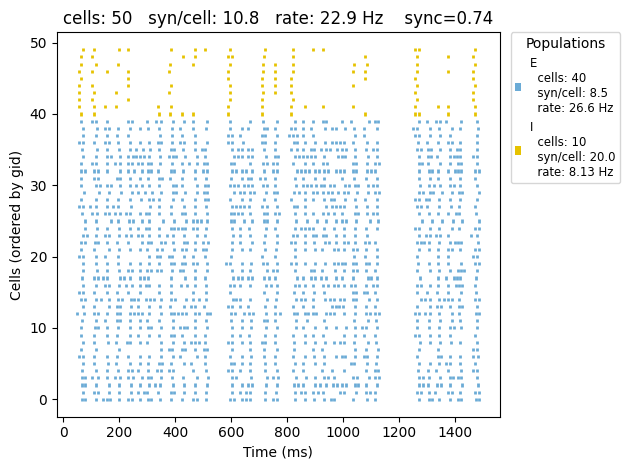

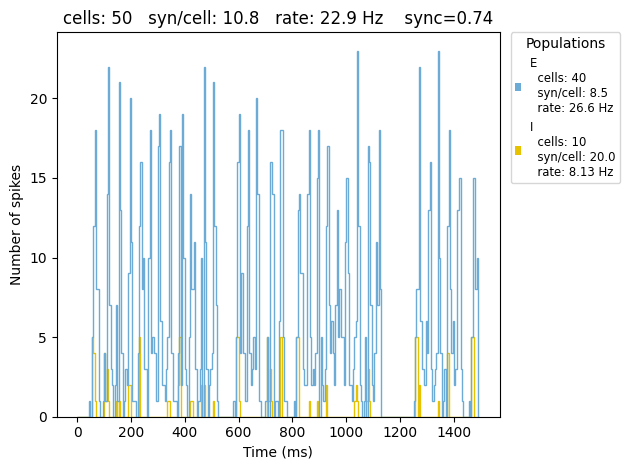

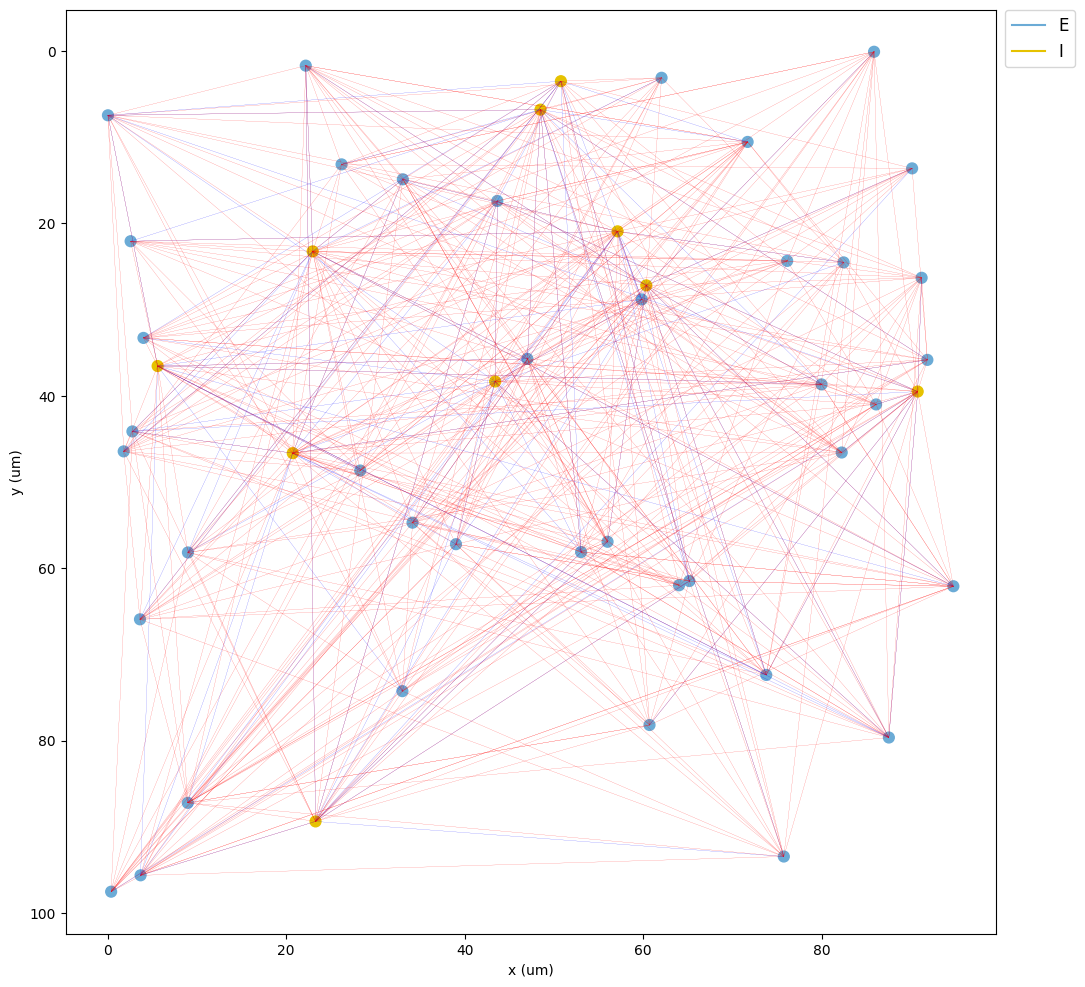

  Done; plotting time = 3.91 s

Total time = 42.79 s


In [12]:

# Simulation options
simConfig = specs.SimConfig()       # object of class SimConfig to store simulation configuration

simConfig.duration = 1500          # Duration of the simulation, in ms
simConfig.dt = 0.01                # Internal integration timestep to use
simConfig.verbose = False           # Show detailed messages
simConfig.recordTraces = {'V_soma':{'sec':'soma','loc':0.5,'var':'v'}}  # Dict with traces to record
simConfig.recordStep = 0.1          # Step size in ms to save data (eg. V traces, LFP, etc)
simConfig.filename = 'raster'  # Set file output name
simConfig.saveJson = False

# simConfig.analysis['plotTraces'] = {'include': [1], 'saveFig': True}  # Plot recorded traces for this list of cells
simConfig.analysis['plotRaster'] = {'showFig': True}                  # Plot a raster
simConfig.analysis['plotSpikeHist'] = {'include': ['E', 'I'], 'showFig': True}
simConfig.analysis['plot2Dnet'] = {'saveFig': True}                   # plot 2D cell positions and connections
# simConfig.analysis['plotRateSpectrogram'] = {'include': ['all'], 'saveFig': True}

# Create network and run simulation
sim.createSimulateAnalyze(netParams = netParams, simConfig = simConfig)    